# Relax Data Science Challenge

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period, identify which factors predict future user
adoption.

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
usersDF = pd.read_csv("takehome_users.csv", encoding = 'latin') # default encoding didn't work - unknown characters
engagementDF = pd.read_csv("takehome_user_engagement.csv")

In [3]:
usersDF.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [12]:
usersDF.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagementDF.columns

Index(['time_stamp', 'user_id', 'visited'], dtype='object')

The first step is to identify which users are the "adopted users" according to the criteria provided in the prompt. The user engagement dataset will have the relevant information for this.

In [5]:
engagementDF.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [6]:
engagementDF['time_stamp'] = pd.to_datetime(engagementDF['time_stamp'])
engagementDF = engagementDF.set_index('time_stamp')
engagementDF.sort_index(inplace = True)

In [7]:
numvisits = engagementDF.groupby('user_id')['visited'].rolling('7d').sum()
adoptedusersDF = numvisits[numvisits > 3].reset_index()
adopted_users = set(adoptedusersDF['user_id'])

In [13]:
# new binary column marking 1 for users that are "adopted"
usersDF['adopted'] = np.where(usersDF['object_id'].isin(adopted_users), 1, 0)

Now, let's pull out the columns that encode features that we might imagine could have an impact on adoption and see if any of them correlate with the ['adopted'] column.

In [20]:
print(usersDF.columns)
print(usersDF.dtypes)

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')
object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                         int32
dtype: object


In [21]:
# user id (object_id) is index+1
boolCols = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted'] 
usersDF[boolCols].corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted
opted_in_to_mailing_list,1.000000,0.483529,0.009551
enabled_for_marketing_drip,0.483529,1.000000,0.002496
adopted,0.009551,0.002496,1.000000


Opting in to mailing list and being on the regular marketing drip correlate quite well with each other (not particularly surprisingly), but neither one seems to be a strong predictor for whether users will adopt the product. We might guess that creation source matters; or that some subset of the organizations or users lead to high product adoption. Let's take a look!

In [39]:
# setting font sizes for figure
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

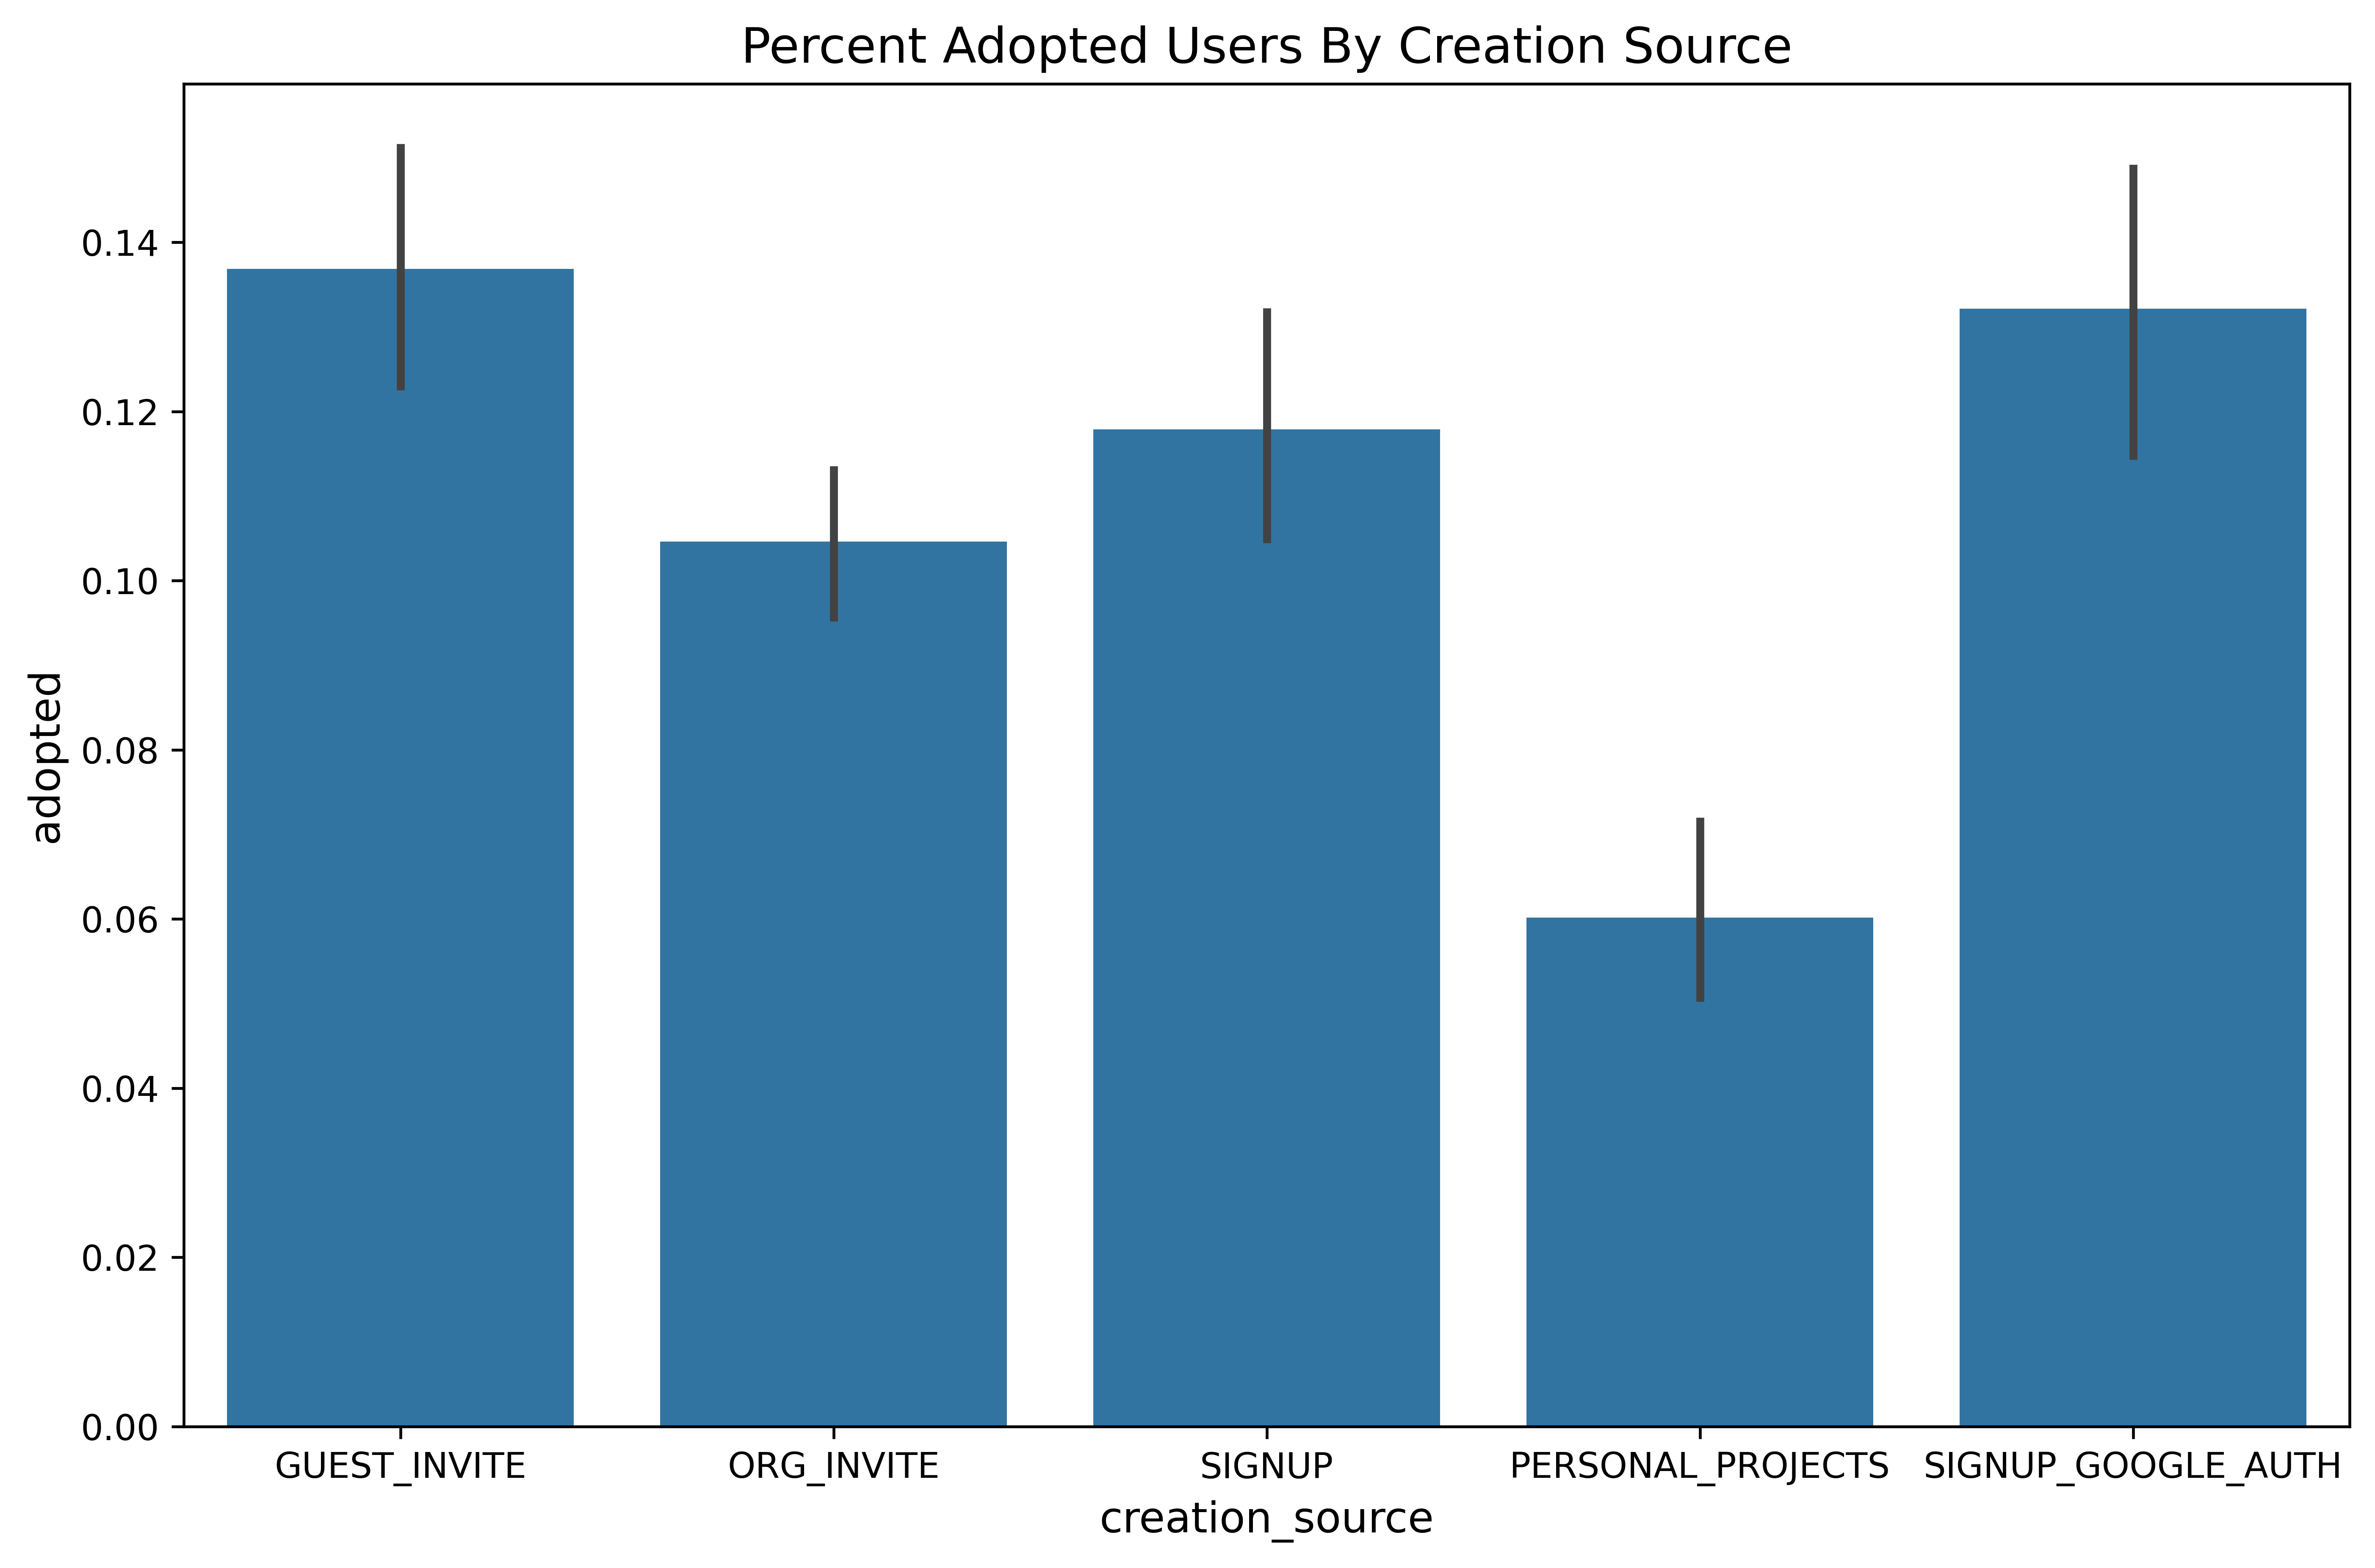

In [40]:
plt.figure(figsize = (11, 7), dpi = 600)
sns.barplot(usersDF, x = 'creation_source', y = 'adopted')
plt.title('Percent Adopted Users By Creation Source')
plt.show()

In [51]:
usersDF.groupby('creation_source')['object_id'].count()

creation_source
GUEST_INVITE          2163
ORG_INVITE            4254
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: object_id, dtype: int64

From the above, it looks we are getting about the same number of signups from most sources. Exceptions are organizational invites, which number fourgly twice as many, and Google Authorization signups, which are a bit lower than the others. <b>The personal project sign ups look quite a bit lower than the others in terms of adoption.</b> The other four source are pretty clothes; there may be significant differences that we could tease out, but it is unlikely to be worth the effort at this stage. This can be something to return to if we have additional information or a particular approach that we are considering related to these categories.

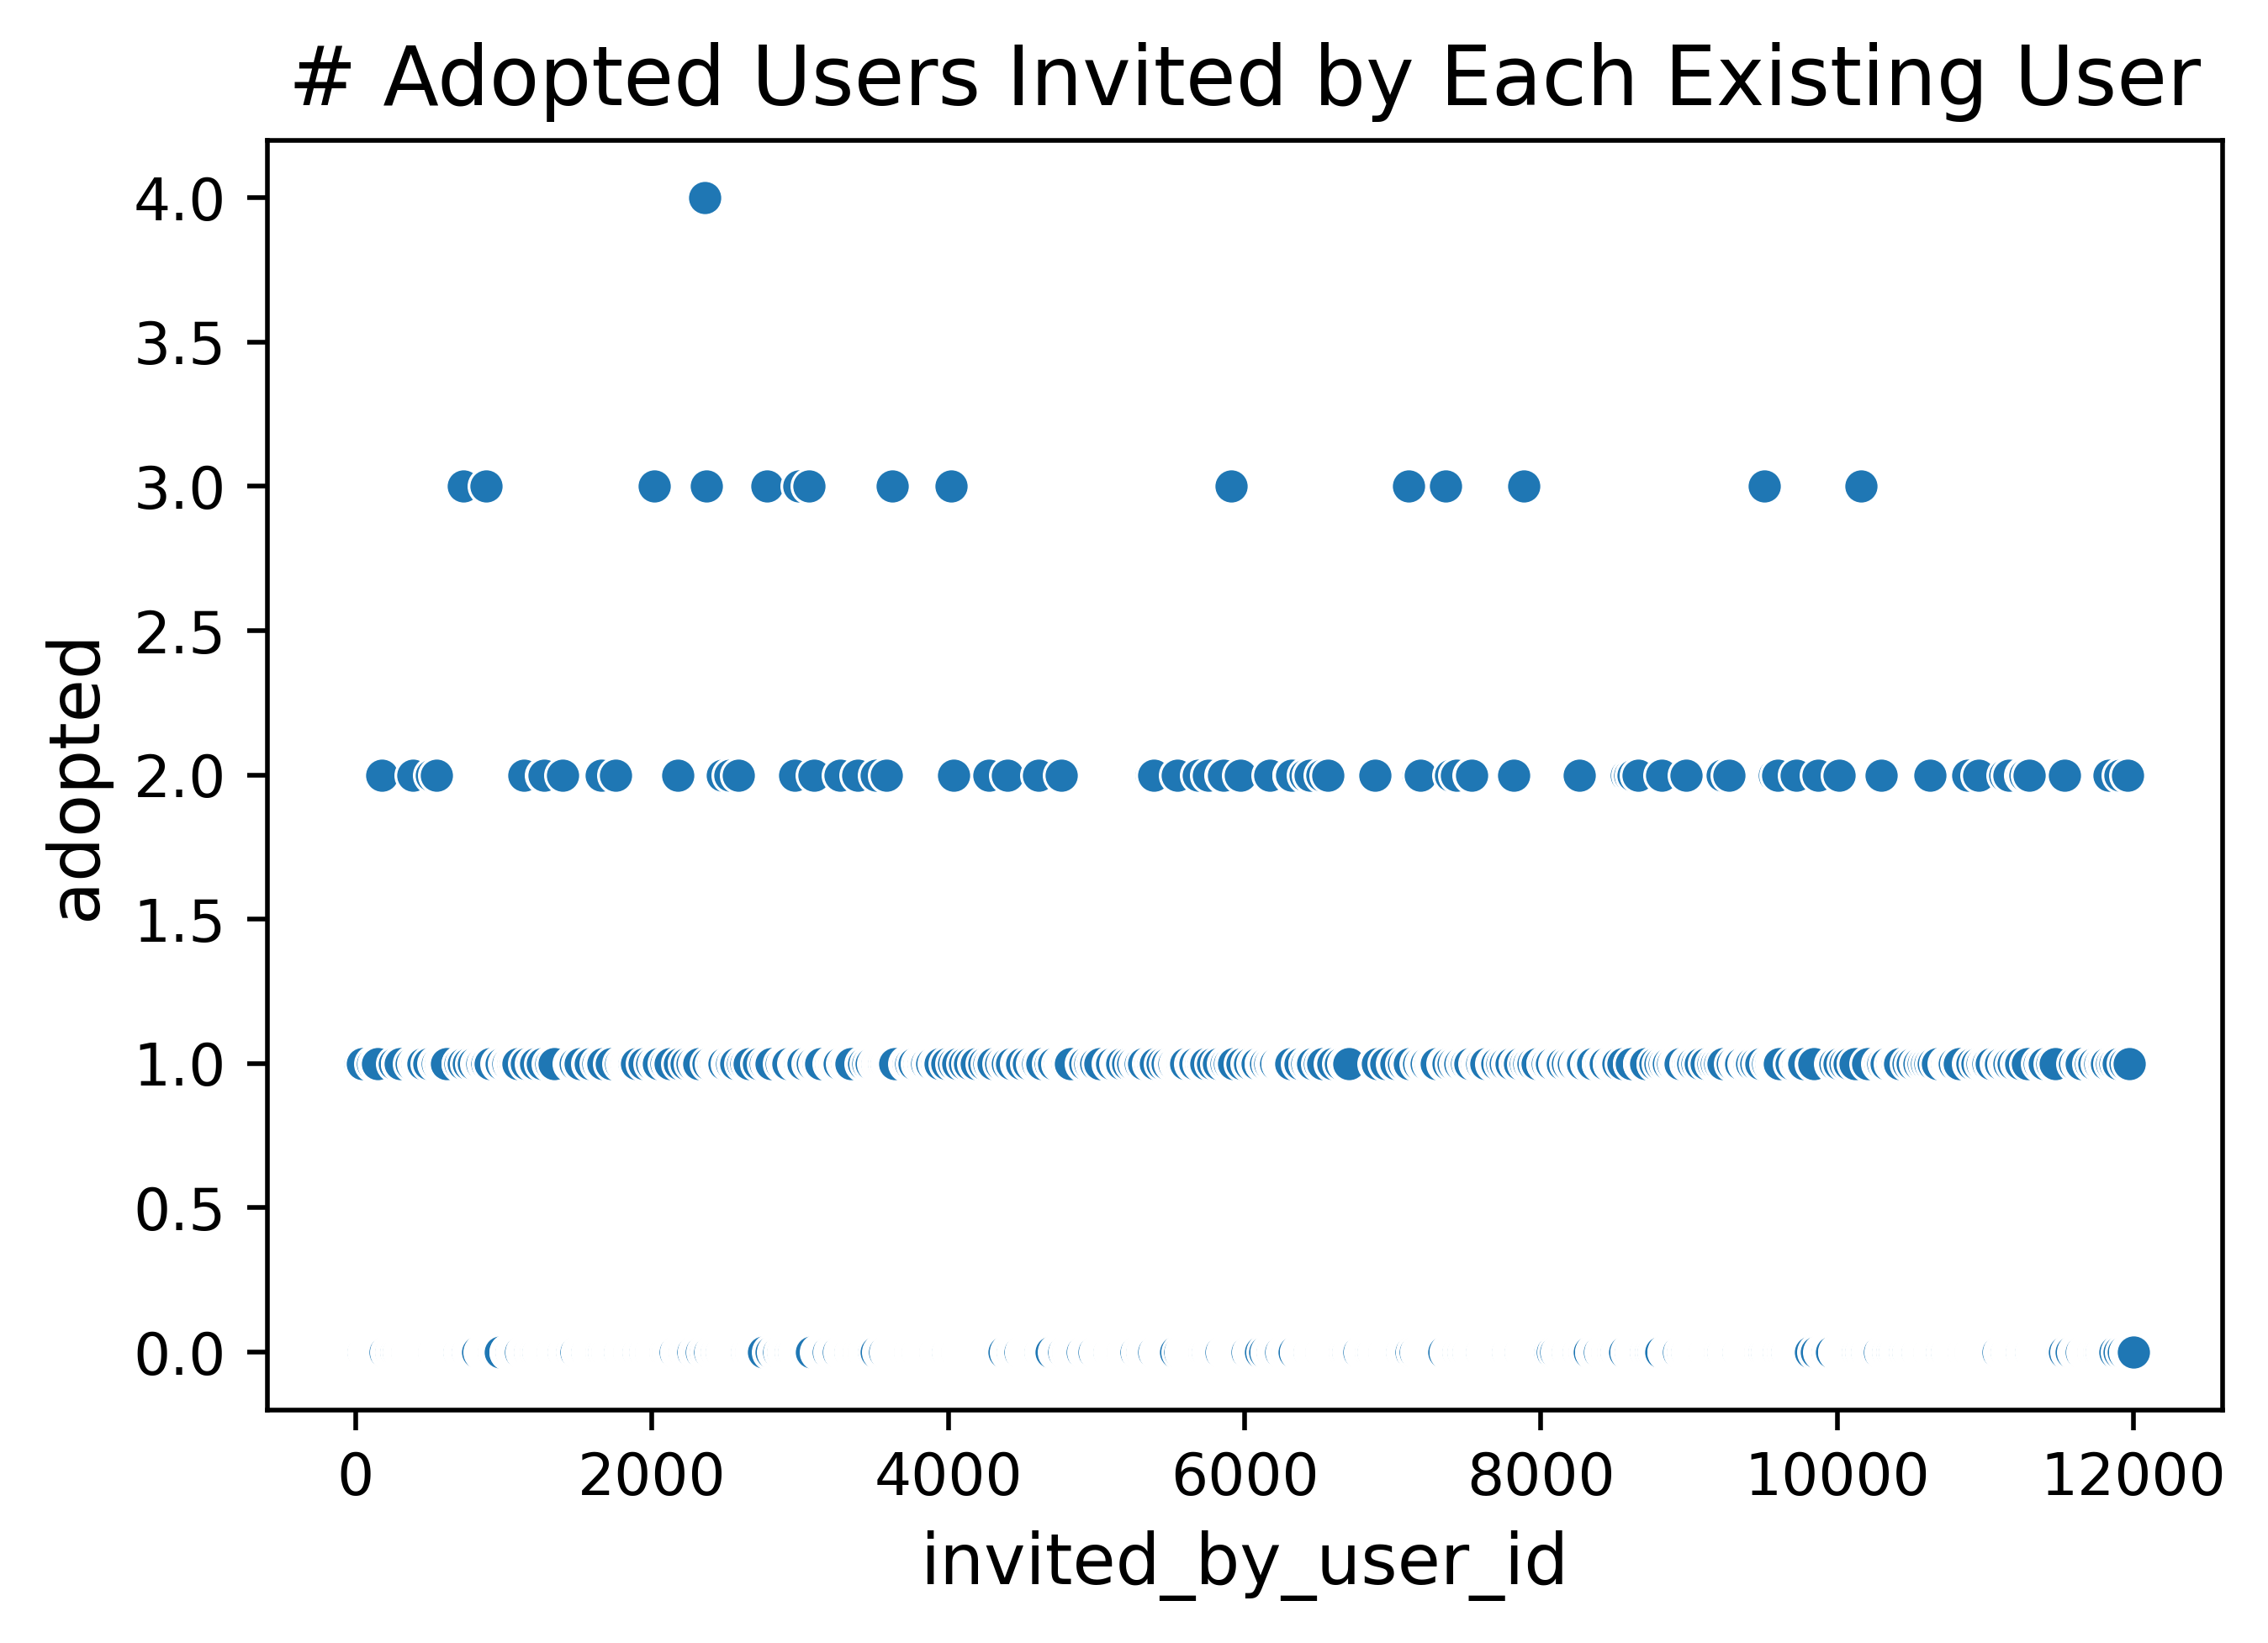

In [55]:
sumByInviteUser = usersDF.groupby('invited_by_user_id')['adopted'].sum()

plt.figure(dpi = 500)
sns.scatterplot(sumByInviteUser)
plt.title('# Adopted Users Invited by Each Existing User')
plt.show()

There are certainly differences between users, and we could potentially tease out which users' invites are more likely to lead to adoption. However, since the maximum here is still only 4 adopted users for one standout star, it doesn't seem likely to be worth the effort on either the modeling/data side or the marketing/outreach side.

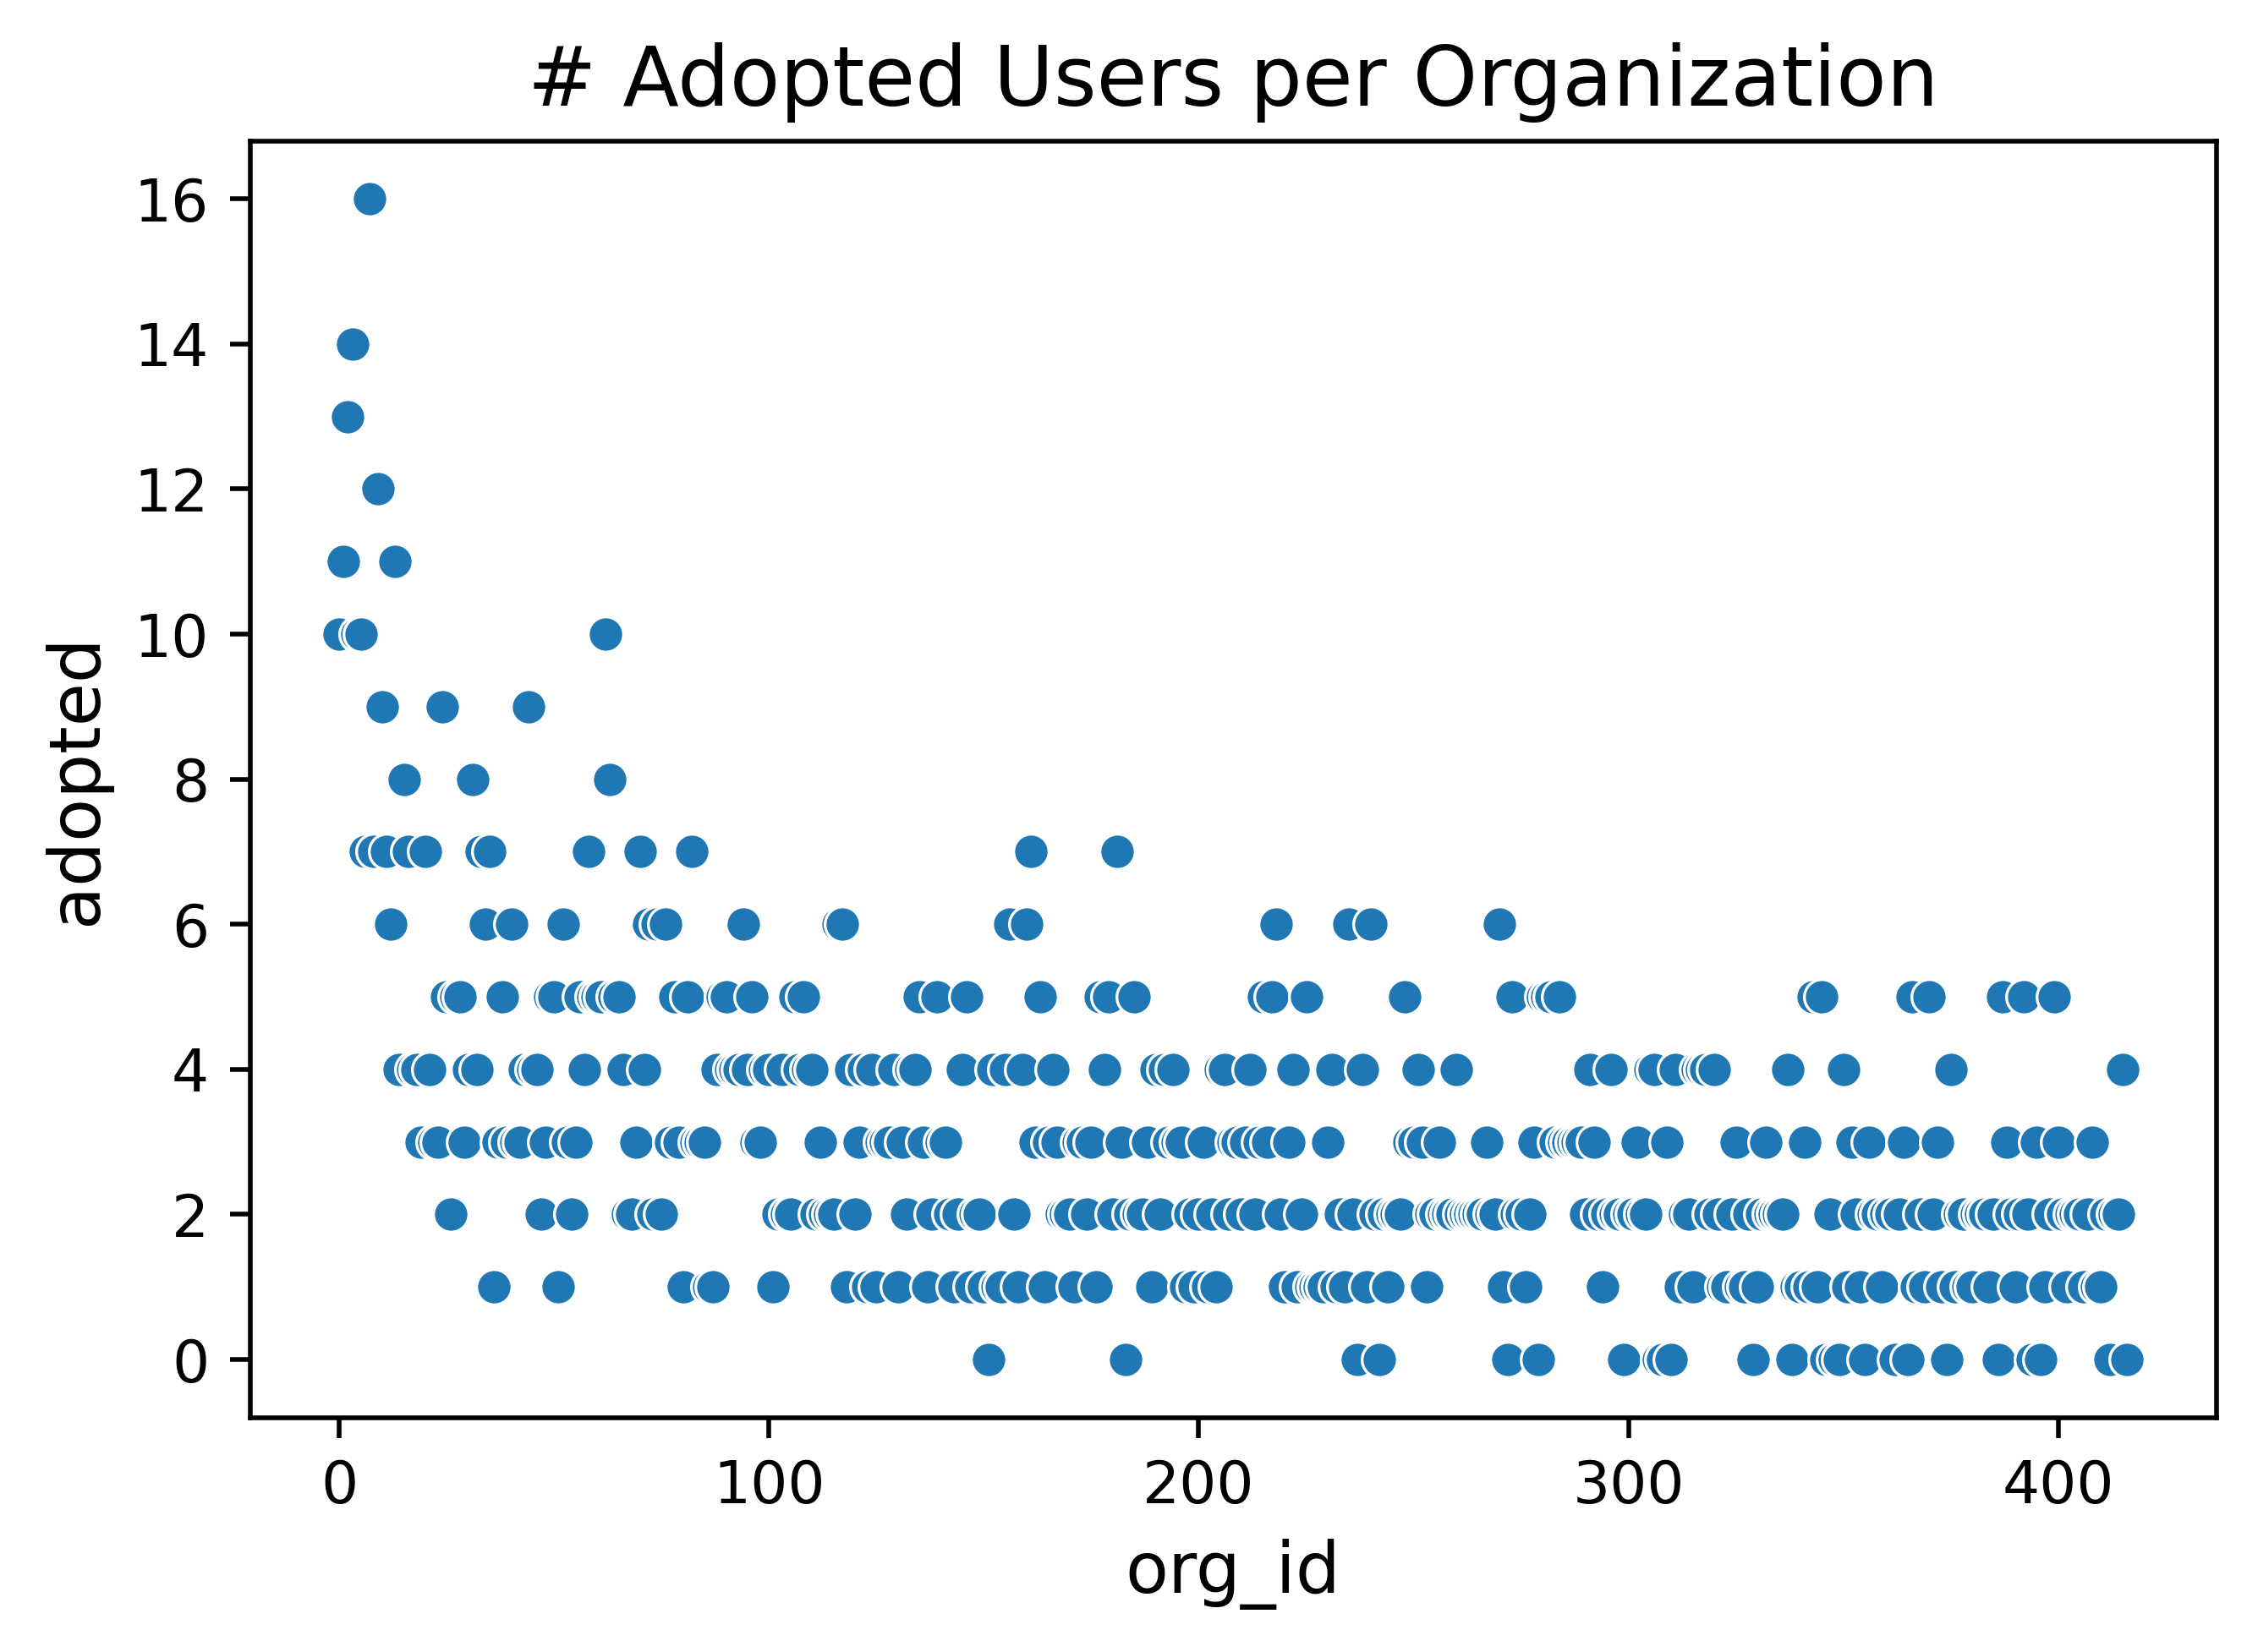

In [56]:
sumByInviteOrg = usersDF.groupby('org_id')['adopted'].sum()

plt.figure(dpi = 500)
sns.scatterplot(sumByInviteOrg)
plt.title('# Adopted Users per Organization')
plt.show()

In [59]:
sumByInviteOrg[sumByInviteOrg >= 10]

org_id
0     10
1     11
2     13
3     14
4     10
5     10
7     16
9     12
13    11
62    10
Name: adopted, dtype: int32

There is a larger range by organization ID than by referring user ID. Listed above are the 10 organization ids that correspond to at least 10 adopted users. It would be interesting to see if there are common threads here to pull: what is the size of the organizations? what is the nature of the referral - mandated? subsidized? All in all, this suggests that investigating a B2B product/version/marketing approach might be valuable. This would involve further probing to understand:
1. How organizational referrals are occurring and how they generally work within the organization.
2. What features of organizations correlate with user adoption
3. Which organizational needs or interests our product is addressing
4. Resource requirements and company interest in features that might lead to referrals from new organizations that would expect to have a high percentage of user adoption